In [1]:
import pandas as pd
import stock_data as stock
from tqdm import tqdm

## Get top50

In [ ]:
start = "2010-01-01"
end = "2021-12-31"
mode = "all"

scrapy = stock.Scrapy()
df0 = scrapy.get_price(start, end, mode)

In [ ]:
df0["Date"] = df0["Date"].apply(lambda X: X.date())
df0["Year"] = df0["Date"].apply(lambda X: X.year)
g = df0.groupby(["Symbol", "Year"])
cat = g.size().keys()

data = []
for i in tqdm(range(len(cat))):
    sample = []
    df1 = g.get_group(cat[i])
    min_ = df1.loc[df1["Close"].idxmin()][["Date", "Close"]].values
    max_ = df1.loc[df1["Close"].idxmax()][["Date", "Close"]].values
    return_ = (df1["Close"].max() - df1["Close"].min()) / df1["Close"].min()

    sample.extend(list(cat[i]))
    sample.extend(min_)
    sample.extend(max_)
    sample.append(return_)
    data.append(sample)
df = pd.DataFrame(data, columns = ["symbol", "year", "min_date", "min_price", "max_date", "max_price", "return"])
df

In [ ]:
df["market"] = df["symbol"].apply(lambda X: X.split(".")[-1])
df["symbol"] = df["symbol"].str[:4]
df = df.query("min_price >= 5")
df = df.reset_index(drop = True)
df

In [ ]:
df = df.query("max_date > min_date")
df = df.reset_index(drop = True)
df

In [ ]:
g = df.groupby(["year", "market"])
cat = g.size().keys()

df2 = pd.DataFrame()
for i in tqdm(range(len(cat))):
    df1 = g.get_group(cat[i])
    df2 = pd.concat([df2, df1.nlargest(50, "return")], ignore_index = True)
df2 = df2.sort_values(["year", "market", "return"])
df2 = df2[['year', 'market', 'symbol', 'min_date', 'min_price', 'max_date', 'max_price', 'return']]
df2["return"] = df2["return"].round(4)
df2

In [ ]:
df2.to_csv("data/top50.csv", index = False)

## Get financial data

In [ ]:
import stock_data as stock

scrapy = stock.Scrapy()
state = scrapy.get_financial_statement(
    type_ = 1,
    clean = 1, 
    mode = "all",
    start_year = 102, 
    end_year = 111
)
state.to_csv("data/income102_111.csv", index = False)

In [ ]:
import stock_data as stock

scrapy = stock.Scrapy()
state = scrapy.get_financial_statement(
    type_ = 2,
    clean = 1, 
    mode = "all",
    start_year = 102, 
    end_year = 111
)
state.to_csv("data/balance102_111.csv", index = False)

## Merge

In [2]:
df1 = pd.read_csv("data/top50.csv")
df1 = df1.query("year >= 2014")
df1 = df1.reset_index(drop = True)
df1.head()

,year,market,symbol,min_date,min_price,max_date,max_price,return
0,2014,TW,1256,2014-01-13,120.56,2014-07-01,245.46,1.0360
1,2014,TW,3038,2014-01-06,5.79,2014-07-17,11.80,1.0380
2,2014,TW,6409,2014-02-17,125.37,2014-12-16,255.85,1.0408
3,2014,TW,4106,2014-02-05,31.75,2014-12-23,65.30,1.0567
4,2014,TW,4994,2014-02-13,79.65,2014-08-12,164.43,1.0644


In [3]:
df2 = pd.read_csv("data/income102_111.csv")
df2 = df2.query("season == 4")
df2["year"] = df2["year"] + 1911
df2 = df2[["year", "公司代號", "每股盈餘(元)"]]
df2.columns = ["year", "symbol", "eps"]
df2 = df2.sort_values(["symbol", "year"])
df2 = df2.reset_index(drop = True)
df2.head()

,year,symbol,eps
0,2013,1101,2.72
1,2014,1101,2.93
2,2015,1101,1.56
3,2016,1101,1.72
4,2017,1101,2.03


In [4]:
df3 = pd.read_csv("data/balance102_111.csv")
df3 = df3.query("season == 4")
df3["year"] = df3["year"] + 1911
df3 = df3[["year", "公司代號", "股本"]]
df3.columns = ["year", "symbol", "capital"]
df3 = df3.sort_values(["symbol", "year"])
df3 = df3.reset_index(drop = True)
df3.head()

,year,symbol,capital
0,2013,1101,36921759.0
1,2014,1101,36921759.0
2,2015,1101,36921759.0
3,2016,1101,36921759.0
4,2017,1101,42465090.0


In [5]:
for i in range(1, df2["year"].nunique()):
    df2[f"last{i}_eps"] = df2.groupby("symbol")["eps"].shift(i)
df2 = df2.iloc[:, :5]
df2

,year,symbol,eps,last1_eps,last2_eps
0,2013,1101,2.72,NaN,NaN
1,2014,1101,2.93,2.72,NaN
2,2015,1101,1.56,2.93,2.72
3,2016,1101,1.72,1.56,2.93
4,2017,1101,2.03,1.72,1.56
...,...,...,...,...,...
15205,2017,9962,0.66,0.74,-0.73
15206,2018,9962,1.04,0.66,0.74
15207,2019,9962,0.13,1.04,0.66
15208,2020,9962,0.01,0.13,1.04


In [6]:
df = pd.merge(df1, df2, left_on = ["year", "symbol"], right_on = ["year", "symbol"], how = "left")
df = df.reset_index(drop = True)
print(len(df))
df.head()

800


,year,market,symbol,min_date,min_price,max_date,max_price,return,eps,last1_eps,last2_eps
0,2014,TW,1256,2014-01-13,120.56,2014-07-01,245.46,1.0360,9.85,12.27,NaN
1,2014,TW,3038,2014-01-06,5.79,2014-07-17,11.80,1.0380,0.79,0.23,NaN
2,2014,TW,6409,2014-02-17,125.37,2014-12-16,255.85,1.0408,14.33,10.20,NaN
3,2014,TW,4106,2014-02-05,31.75,2014-12-23,65.30,1.0567,2.14,1.60,NaN
4,2014,TW,4994,2014-02-13,79.65,2014-08-12,164.43,1.0644,3.98,4.25,NaN


In [7]:
df3["last_capital"] = df3.groupby("symbol")["capital"].shift()
df3 = df3.dropna()
df3

,year,symbol,capital,last_capital
1,2014,1101,36921759.0,36921759.0
2,2015,1101,36921759.0,36921759.0
3,2016,1101,36921759.0,36921759.0
4,2017,1101,42465090.0,36921759.0
5,2018,1101,53080599.0,42465090.0
...,...,...,...,...
15205,2017,9962,902203.0,902203.0
15206,2018,9962,902203.0,902203.0
15207,2019,9962,902203.0,902203.0
15208,2020,9962,902203.0,902203.0


In [8]:
df = pd.merge(df, df3, left_on = ["year", "symbol"], right_on = ["year", "symbol"], how = "left")
df = df.reset_index(drop = True)
print(len(df))
df.head()

800


,year,market,symbol,min_date,min_price,max_date,max_price,return,eps,last1_eps,last2_eps,capital,last_capital
0,2014,TW,1256,2014-01-13,120.56,2014-07-01,245.46,1.0360,9.85,12.27,NaN,246960.0,176400.0
1,2014,TW,3038,2014-01-06,5.79,2014-07-17,11.80,1.0380,0.79,0.23,NaN,2261076.0,2261076.0
2,2014,TW,6409,2014-02-17,125.37,2014-12-16,255.85,1.0408,14.33,10.20,NaN,708435.0,616400.0
3,2014,TW,4106,2014-02-05,31.75,2014-12-23,65.30,1.0567,2.14,1.60,NaN,833855.0,833855.0
4,2014,TW,4994,2014-02-13,79.65,2014-08-12,164.43,1.0644,3.98,4.25,NaN,884880.0,705960.0


In [9]:
df = df.query("(min_price >= 10) & (min_price <= 50)")
df = df.query("eps >= last1_eps")
df = df.query("(eps > 0) & (last1_eps > 0) & (last2_eps > 0)")
df = df.query("(eps > (last1_eps * 1.5)) & (last1_eps > (last2_eps * 1.5))")
df = df.query("capital >= last_capital")

In [10]:
df["eps_return"] = df.eval("eps / last1_eps - 1")
df["eps_return_last2"] = df.eval("last1_eps / last2_eps - 1")

In [11]:
df

,year,market,symbol,min_date,min_price,max_date,max_price,return,eps,last1_eps,last2_eps,capital,last_capital,eps_return,eps_return_last2
103,2015,TW,2383,2015-01-08,39.30,2015-08-10,75.90,0.9313,7.55,4.91,2.69,3175051.0,3159941.0,0.537678,0.825279
109,2015,TW,3413,2015-08-24,39.32,2015-12-08,77.31,0.9662,8.11,5.38,1.64,680000.0,600000.0,0.507435,2.280488
125,2015,TW,4968,2015-01-05,23.91,2015-12-03,54.37,1.2739,3.26,1.35,0.37,498976.0,439156.0,1.414815,2.648649
163,2015,TWO,5474,2015-01-06,37.75,2015-04-24,92.92,1.4615,6.34,4.16,2.68,337298.0,337298.0,0.524038,0.552239
168,2015,TWO,4420,2015-07-09,23.36,2015-10-16,62.47,1.6742,3.33,1.03,0.07,294550.0,294550.0,2.233010,13.714286
189,2015,TWO,3234,2015-01-09,34.55,2015-11-05,117.00,2.3864,8.04,2.93,0.98,1038261.0,1010353.0,1.744027,1.989796
199,2015,TWO,3205,2015-01-08,26.95,2015-11-20,320.54,10.8939,11.81,0.41,0.02,284288.0,247128.0,27.804878,19.500000
279,2016,TWO,3324,2016-01-05,37.43,2016-08-10,115.00,2.0724,8.36,2.42,0.22,791381.0,711362.0,2.454545,10.000000
312,2017,TW,4540,2017-01-03,18.54,2017-11-10,52.18,1.8145,2.50,0.54,0.30,852780.0,852780.0,3.629630,0.800000
327,2017,TW,4739,2017-01-17,40.63,2017-10-19,143.68,2.5363,5.40,3.01,1.71,864737.0,757254.0,0.794020,0.760234


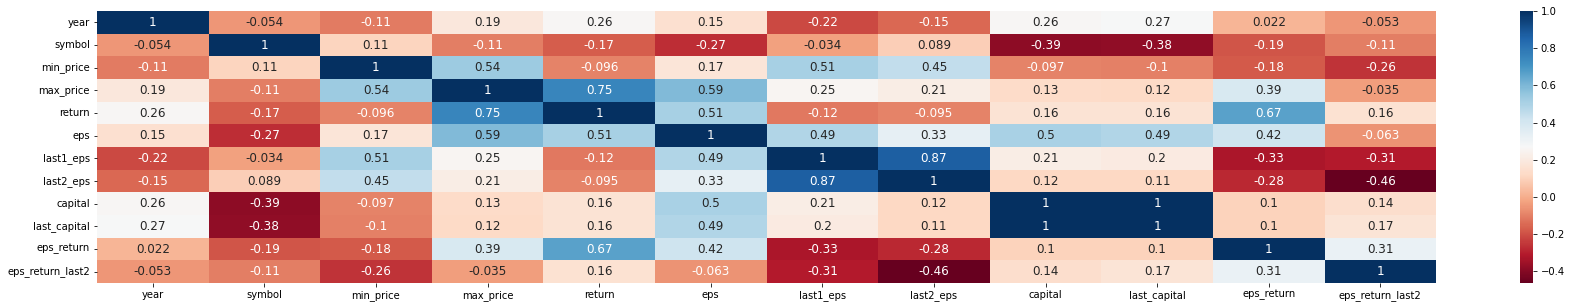

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30, 5))
sns.heatmap(data = df.corr(), annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 12})
plt.show()

## Analysis

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df["eps_diff"] = df["eps"] - df["last1_eps"]
df.head(3)

,year,market,symbol,min_date,min_price,max_date,max_price,return,eps,last1_eps,last2_eps,capital,last_capital,eps_return,eps_return_last2,eps_diff
103,2015,TW,2383,2015-01-08,39.30,2015-08-10,75.90,0.9313,7.55,4.91,2.69,3175051.0,3159941.0,0.537678,0.825279,2.64
109,2015,TW,3413,2015-08-24,39.32,2015-12-08,77.31,0.9662,8.11,5.38,1.64,680000.0,600000.0,0.507435,2.280488,2.73
125,2015,TW,4968,2015-01-05,23.91,2015-12-03,54.37,1.2739,3.26,1.35,0.37,498976.0,439156.0,1.414815,2.648649,1.91


<AxesSubplot:xlabel='eps_diff', ylabel='return'>

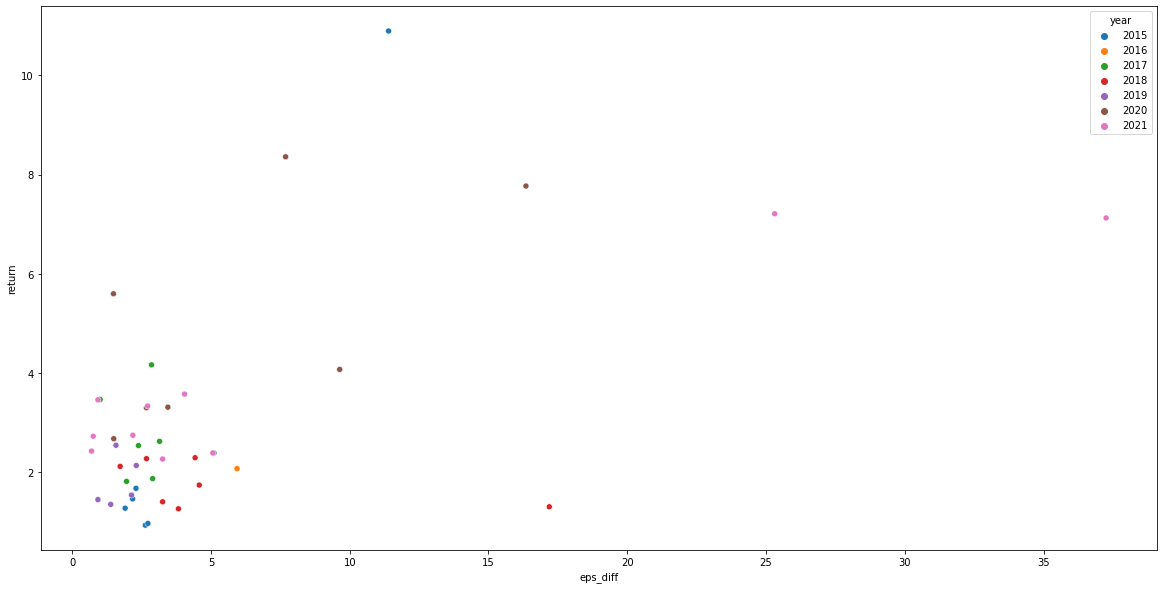

In [15]:
plt.figure(figsize = (20, 10))
sns.color_palette("tab10")
sns.scatterplot(x = "eps_diff", y = "return", data = df, hue = "year", palette = "tab10")